# Calibration of LLM-Based Survey Simulation on PLS 2020 AE Data
This notebook walks through Huang et al. (2025) “Uncertainty Quantification for LLM-Based Survey Simulations” on binary outcomes, using the FY2020 Public Library Survey AE file. We focus on columns **VISITS**, **TOTCIR**, and **TOTPRO**.

## 1. Setup
Import necessary libraries and define parameters.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
DATA_PATH = 'Data/PLS2020/PLS_FY20_AE_pud20i.csv'
vars_of_interest = ['VISITS', 'TOTCIR', 'TOTPRO']
m = len(vars_of_interest)   # number of variables
K = 100                     # max synthetic sample size
alpha = 0.05                # target miscoverage rate
c = np.sqrt(2)              # dilation factor
bias = 0.1                  # fixed LLM bias for simulation

## 2. Load & Inspect Data
Read the AE CSV and inspect the first rows.

In [2]:
df = pd.read_csv(DATA_PATH, encoding='latin1')
df.head()

,STABR,FSCSKEY,LIBID,LIBNAME,ADDRESS,CITY,ZIP,ZIP4,ADDRES_M,CITY_M,...,C19ECRD1,C19ECRD2,C19REFER,C19OUTSD,C19LIVEP,C19RECDP,C19XWIF1,C19XWIF2,C19XWIF3,C19STOTH
0,AK,AK0001,AK0001-002,ANCHOR POINT PUBLIC LIBRARY,34020 NORTH FORK ROAD,ANCHOR POINT,99556,9150,P.O. BOX 129,ANCHOR POINT,...,N,N,Y,Y,N,N,Y,Y,Y,N
1,AK,AK0002,AK0002-011,ANCHORAGE PUBLIC LIBRARY,3600 DENALI STREET,ANCHORAGE,99503,6055,3600 DENALI STREET,ANCHORAGE,...,Y,Y,Y,N,Y,Y,Y,Y,N,Y
2,AK,AK0003,AK0003-002,ANDERSON COMMUNITY LIBRARY,101 FIRST STREET,ANDERSON,99744,M,P.O. BOX 3078,ANDERSON,...,N,N,N,N,N,N,Y,N,Y,N
3,AK,AK0006,AK0006-002,KUSKOKWIM CONSORTIUM LIBRARY,420 CHIEF EDDIE HOFFMAN HIGHWAY,BETHEL,99559,M,P.O. BOX 368,BETHEL,...,N,Y,Y,Y,Y,Y,Y,Y,N,Y
4,AK,AK0007,AK0007-002,BIG LAKE PUBLIC LIBRARY,3140 SOUTH BIG LAKE ROAD,BIG LAKE,99652,9663,P.O. BOX 520829,BIG LAKE,...,N,N,Y,Y,Y,Y,Y,Y,Y,Y


## 3. Binarize Real Outcomes
Threshold each series at its median.

In [3]:
real_data = []
for col in vars_of_interest:
    series = df[col].dropna()
    med = series.median()
    binary = (series > med).astype(int).to_numpy()
    real_data.append(binary)
# Preview first 10
real_data[0][:10]

array([0, 1, 0, 1, 1, 0, 0, 0, 0, 0])

## 4. Calibration Functions
Define the dilated CLT interval and selection rule.

In [4]:
def dilated_clt_interval(samples, alpha, c):
    k = len(samples)
    if k == 0:
        return 0.0, 1.0
    ybar = np.mean(samples)
    s = np.sqrt(ybar * (1 - ybar))
    z = norm.ppf(1 - alpha/2)
    half = c * s / np.sqrt(k) * z
    return max(0.0, ybar - half), min(1.0, ybar + half)

def calibrate_k_star(real_data, llm_data, alpha, c):
    G = np.zeros(K + 1)
    for k in range(K + 1):
        mis = 0
        for rd, syn in zip(real_data, llm_data):
            lo, hi = dilated_clt_interval(syn[:k], alpha, c)
            if not (lo <= rd.mean() <= hi):
                mis += 1
        G[k] = mis / len(real_data)
    valid = [i for i in range(K + 1) if np.all(G[:i + 1] <= alpha/2)]
    return (max(valid) if valid else 0), G

## 5. Simulate LLM Responses
Add bias and sample Bernoulli.

In [5]:
llm_data = []
for arr in real_data:
    p_true = arr.mean()
    p_llm = float(np.clip(p_true + bias, 0, 1))
    llm_data.append(np.random.binomial(1, p_llm, size=K))

## 6. Run Calibration & Plot
Compute k* and plot G(k).

Calibrated synthetic sample size k* = 0


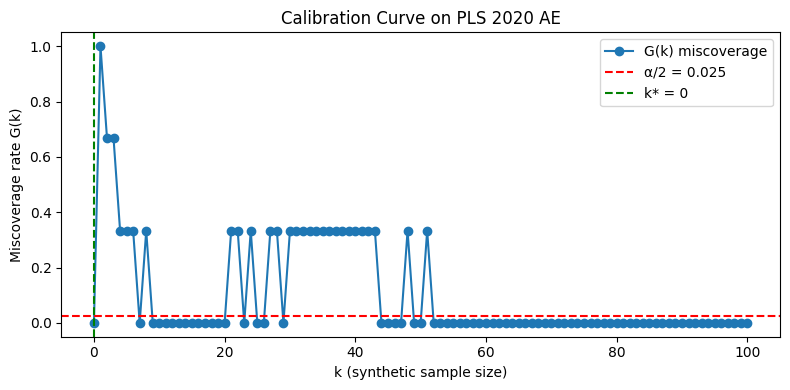

In [6]:
k_star, G = calibrate_k_star(real_data, llm_data, alpha, c)
print(f'Calibrated synthetic sample size k* = {k_star}')
plt.figure(figsize=(8, 4))
plt.plot(G, '-o', label='G(k) miscoverage')
plt.axhline(alpha/2, color='red', linestyle='--', label=f'α/2 = {alpha/2}')
plt.axvline(k_star, color='green', linestyle='--', label=f'k* = {k_star}')
plt.xlabel('k (synthetic sample size)')
plt.ylabel('Miscoverage rate G(k)')
plt.title('Calibration Curve on PLS 2020 AE')
plt.legend()
plt.tight_layout()
plt.show()

### Interpretation
- **G(k)** is the fraction of our variables whose real mean falls outside the LLM-based interval at size k.
- We choose the largest k so that for all i ≤ k, G(i) ≤ α/2.
- A **k* = 0** means even one synthetic sample would exceed the miscoverage threshold, showing large bias.